In [ ]:
#@title Reference
#https://medium.com/call-for-atlas/pairs-trading-strategy-every-stock-needs-a-friend-e50723a1dc94

#Libs

In [2]:
#@title Yfinance instalation
!pip install yfinance

In [3]:
#@title Import libs
import pandas as pd
import numpy as np
import yfinance as yf
import os

from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Functions

In [4]:
#@title Data preparation
def load_ticker_ts_df(ticker, start_date, end_date):
    """
    Load and cache time series financial data from Yahoo Finance API.
    Parameters:
    - ticker (str): The stock ticker symbol (e.g., 'AAPL' for Apple Inc.).
    - start_date (str): The start date in 'YYYY-MM-DD' format for data retrieval.
    - end_date (str): The end date in 'YYYY-MM-DD' format for data retrieval.
    Returns:
    - df (pandas.DataFrame): A DataFrame containing the financial time series data.

    """
    dir_path = './data'
    cached_file_path = f'{dir_path}/{ticker}_{start_date}_{end_date}.pkl'
    try:
        if os.path.exists(cached_file_path):
            df = pd.read_pickle(cached_file_path)
        else:
            df = yf.download(ticker, start=start_date, end=end_date)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            df.to_pickle(cached_file_path)
    except FileNotFoundError:
        print(
            f'Error downloading and caching or loading file with ticker: {ticker}')

    return df


def sanitize_data(data_map):
    TS_DAYS_LENGTH = (pd.to_datetime(END_DATE) -
                      pd.to_datetime(START_DATE)).days
    data_sanitized = {}
    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
    for ticker, data in data_map.items():
        if data is None or len(data) < (TS_DAYS_LENGTH / 2):
            # We cannot handle shorter TSs
            continue
        if len(data) > TS_DAYS_LENGTH:
            # Normalize to have the same length (TS_DAYS_LENGTH)
            data = data[-TS_DAYS_LENGTH:]
        # Reindex the time series to match the date range and fill in any blanks (Not Numbers)
        data = data.reindex(date_range)
        data['Adj Close'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['Adj Close'].interpolate(method='linear', inplace=True)
        data['Adj Close'].fillna(method='pad', inplace=True)
        data['Adj Close'].fillna(method='bfill', inplace=True)
        assert not np.any(np.isnan(data['Adj Close'])) and not np.any(
            np.isinf(data['Adj Close']))
        data_sanitized[ticker] = data
    return data_sanitized


def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    """
    Find cointegrated pairs of stocks based on the Augmented Dickey-Fuller (ADF) test.
    Parameters:
    - tickers_ts_map (dict): A dictionary where keys are stock tickers and values are time series data.
    - p_value_threshold (float): The significance level for cointegration testing.
    Returns:
    - pvalue_matrix (numpy.ndarray): A matrix of cointegration p-values between stock pairs.
    - pairs (list): A list of tuples representing cointegrated stock pairs and their p-values.
    """
    tickers = list(tickers_ts_map.keys())
    n = len(tickers)
    # Extract 'Adj Close' prices into a matrix (each column is a time series)
    adj_close_data = np.column_stack(
        [tickers_ts_map[ticker]['Adj Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))
    # Calculate cointegration p-values for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = coint(adj_close_data[:, i], adj_close_data[:, j])
        pvalue_matrix[i, j] = result[1]
    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j])
             for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]
    return pvalue_matrix, pairs

In [5]:
#@title Strategy integration
def calculate_profit(signals, prices):
    """
    Calculate cumulative profit based on trading signals and stock prices.
    Parameters:
    - signals (pandas.DataFrame): A DataFrame containing trading signals (1 for buy, -1 for sell).
    - prices (pandas.Series): A Series containing stock prices corresponding to the signal dates.
    Returns:
    - cum_profit (pandas.Series): A Series containing cumulative profit over time.
    """
    profit = pd.DataFrame(index=prices.index)
    profit['profit'] = 0.0

    buys = signals[signals['orders'] == 1].index
    sells = signals[signals['orders'] == -1].index
    while sells[0] < buys[0]:
        # These are long only strategies, we cannot start with sell
        sells = sells[1:]

    if len(buys) == 0 or len(sells) == 0:
        # no actions taken
        return profit
    if len(sells) < len(buys):
        # Assume we sell at the end
        sells = sells.append(pd.Index(prices.tail(1).index))

    buy_prices = prices.loc[buys]
    sell_prices = prices.loc[sells]

    profit.loc[sells, 'profit'] = sell_prices.values - buy_prices.values
    profit['profit'] = profit['profit'].fillna(0)

    # Make profit cumulative
    profit['cum_profit'] = profit['profit'].cumsum()

    return profit['cum_profit']


def plot_strategy(prices_df, signal_df, profit):
    """
    Plot a trading strategy with buy and sell signals and cumulative profit.
    Parameters:
    - prices (pandas.Series): A Series containing stock prices.
    - signals (pandas.DataFrame): A DataFrame with buy (1) and sell (-1) signals.
    - profit (pandas.Series): A Series containing cumulative profit over time.
    Returns:
    - ax1 (matplotlib.axes.Axes): The top subplot displaying stock prices and signals.
    - ax2 (matplotlib.axes.Axes): The bottom subplot displaying cumulative profit.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': (3, 1)},
                                   figsize=(18, 12))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price in $')
    ax1.plot(prices_df.index, prices_df, color='g', lw=0.25)

    # Plot the Buy and Sell signals
    ax1.plot(signal_df.loc[signal_df.orders == 1.0].index,
             prices_df[signal_df.orders == 1.0],
             '^', markersize=12, color='blue', label='Buy')
    ax1.plot(signal_df.loc[signal_df.orders == -1.0].index,
             prices_df[signal_df.orders == -1.0],
             'v', markersize=12, color='red', label='Sell')

    ax2.plot(profit.index, profit, color='b')
    ax2.set_ylabel('Cumulative Profit (%)')
    ax2.set_xlabel('Date')

    return ax1, ax2


def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.
    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.
    """
    ratios = ticker1_ts / ticker2_ts
    ratios_mean = ratios.rolling(
        window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(
        window=window_size, min_periods=1, center=False).std()
    z_scores = (ratios - ratios_mean) / ratios_std
    buy = ratios.copy()
    sell = ratios.copy()
    if first_ticker:
        # These are empty zones, where there should be no signal
        # the rest is signalled by the ratio.
        buy[z_scores > -1] = 0
        sell[z_scores < 1] = 0
    else:
        buy[z_scores < 1] = 0
        sell[z_scores > -1] = 0
    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = np.where(buy > 0, 1, np.where(sell < 0, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None
    return signals_df

#Run

##Data part

In [88]:

#@title Load and prepare the data
crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD',
                       'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 'RVN-USD', 'SXP-USD', 'BTCB-USD', 'TON-USD', 'SOL-USD']

bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB',  'CFG',
                'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 'WAL', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC', 'HOMB']

bank_stocks += ["COIN", "RIOT", "MARA", "HUT", "BITF", "SQ", "PYPL", "LC", "SOFI", "UPST", "ARKW", "BLOK", "MSTR", "HOOD", "DKNG", "ICE", "CME", "INTC", "AVGO", "QCOM", "TXN"]

bank_stocks += ["AAPL", "HON", "GE", "CAT", "MMM", "BA", "LMT", "GD", "JNJ", "PFE", "MRK", "ABT", "NVS", "UNH", "PG", "WMT", "KO", "PEP", "XOM", "CVX", "SLB", "COP", "EOG", "OXY", "MPC", "PSX", "VLO", "DOW", "DD", "EMN"]

global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100',
                    '^VIX', '^TNX', '^OEX', '^NDX', '^RUI', '^VIX', '^OSX', '^XAU', '^SOX']

START_DATE = '2021-01-01'
END_DATE = '2024-04-20'
universe_tickers = crypto_forex_stocks + bank_stocks
universe_tickers_ts_map = {ticker: load_ticker_ts_df(
    ticker, START_DATE, END_DATE) for ticker in universe_tickers}

# Sample some
uts_sanitized = sanitize_data(universe_tickers_ts_map)
uts_sanitized['JPM'].shape, uts_sanitized['BTC-USD'].shape

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

((1206, 6), (1206, 6))

<ipython-input-6-6473b450bbce>:72: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  result = coint(adj_close_data[:, i], adj_close_data[:, j])


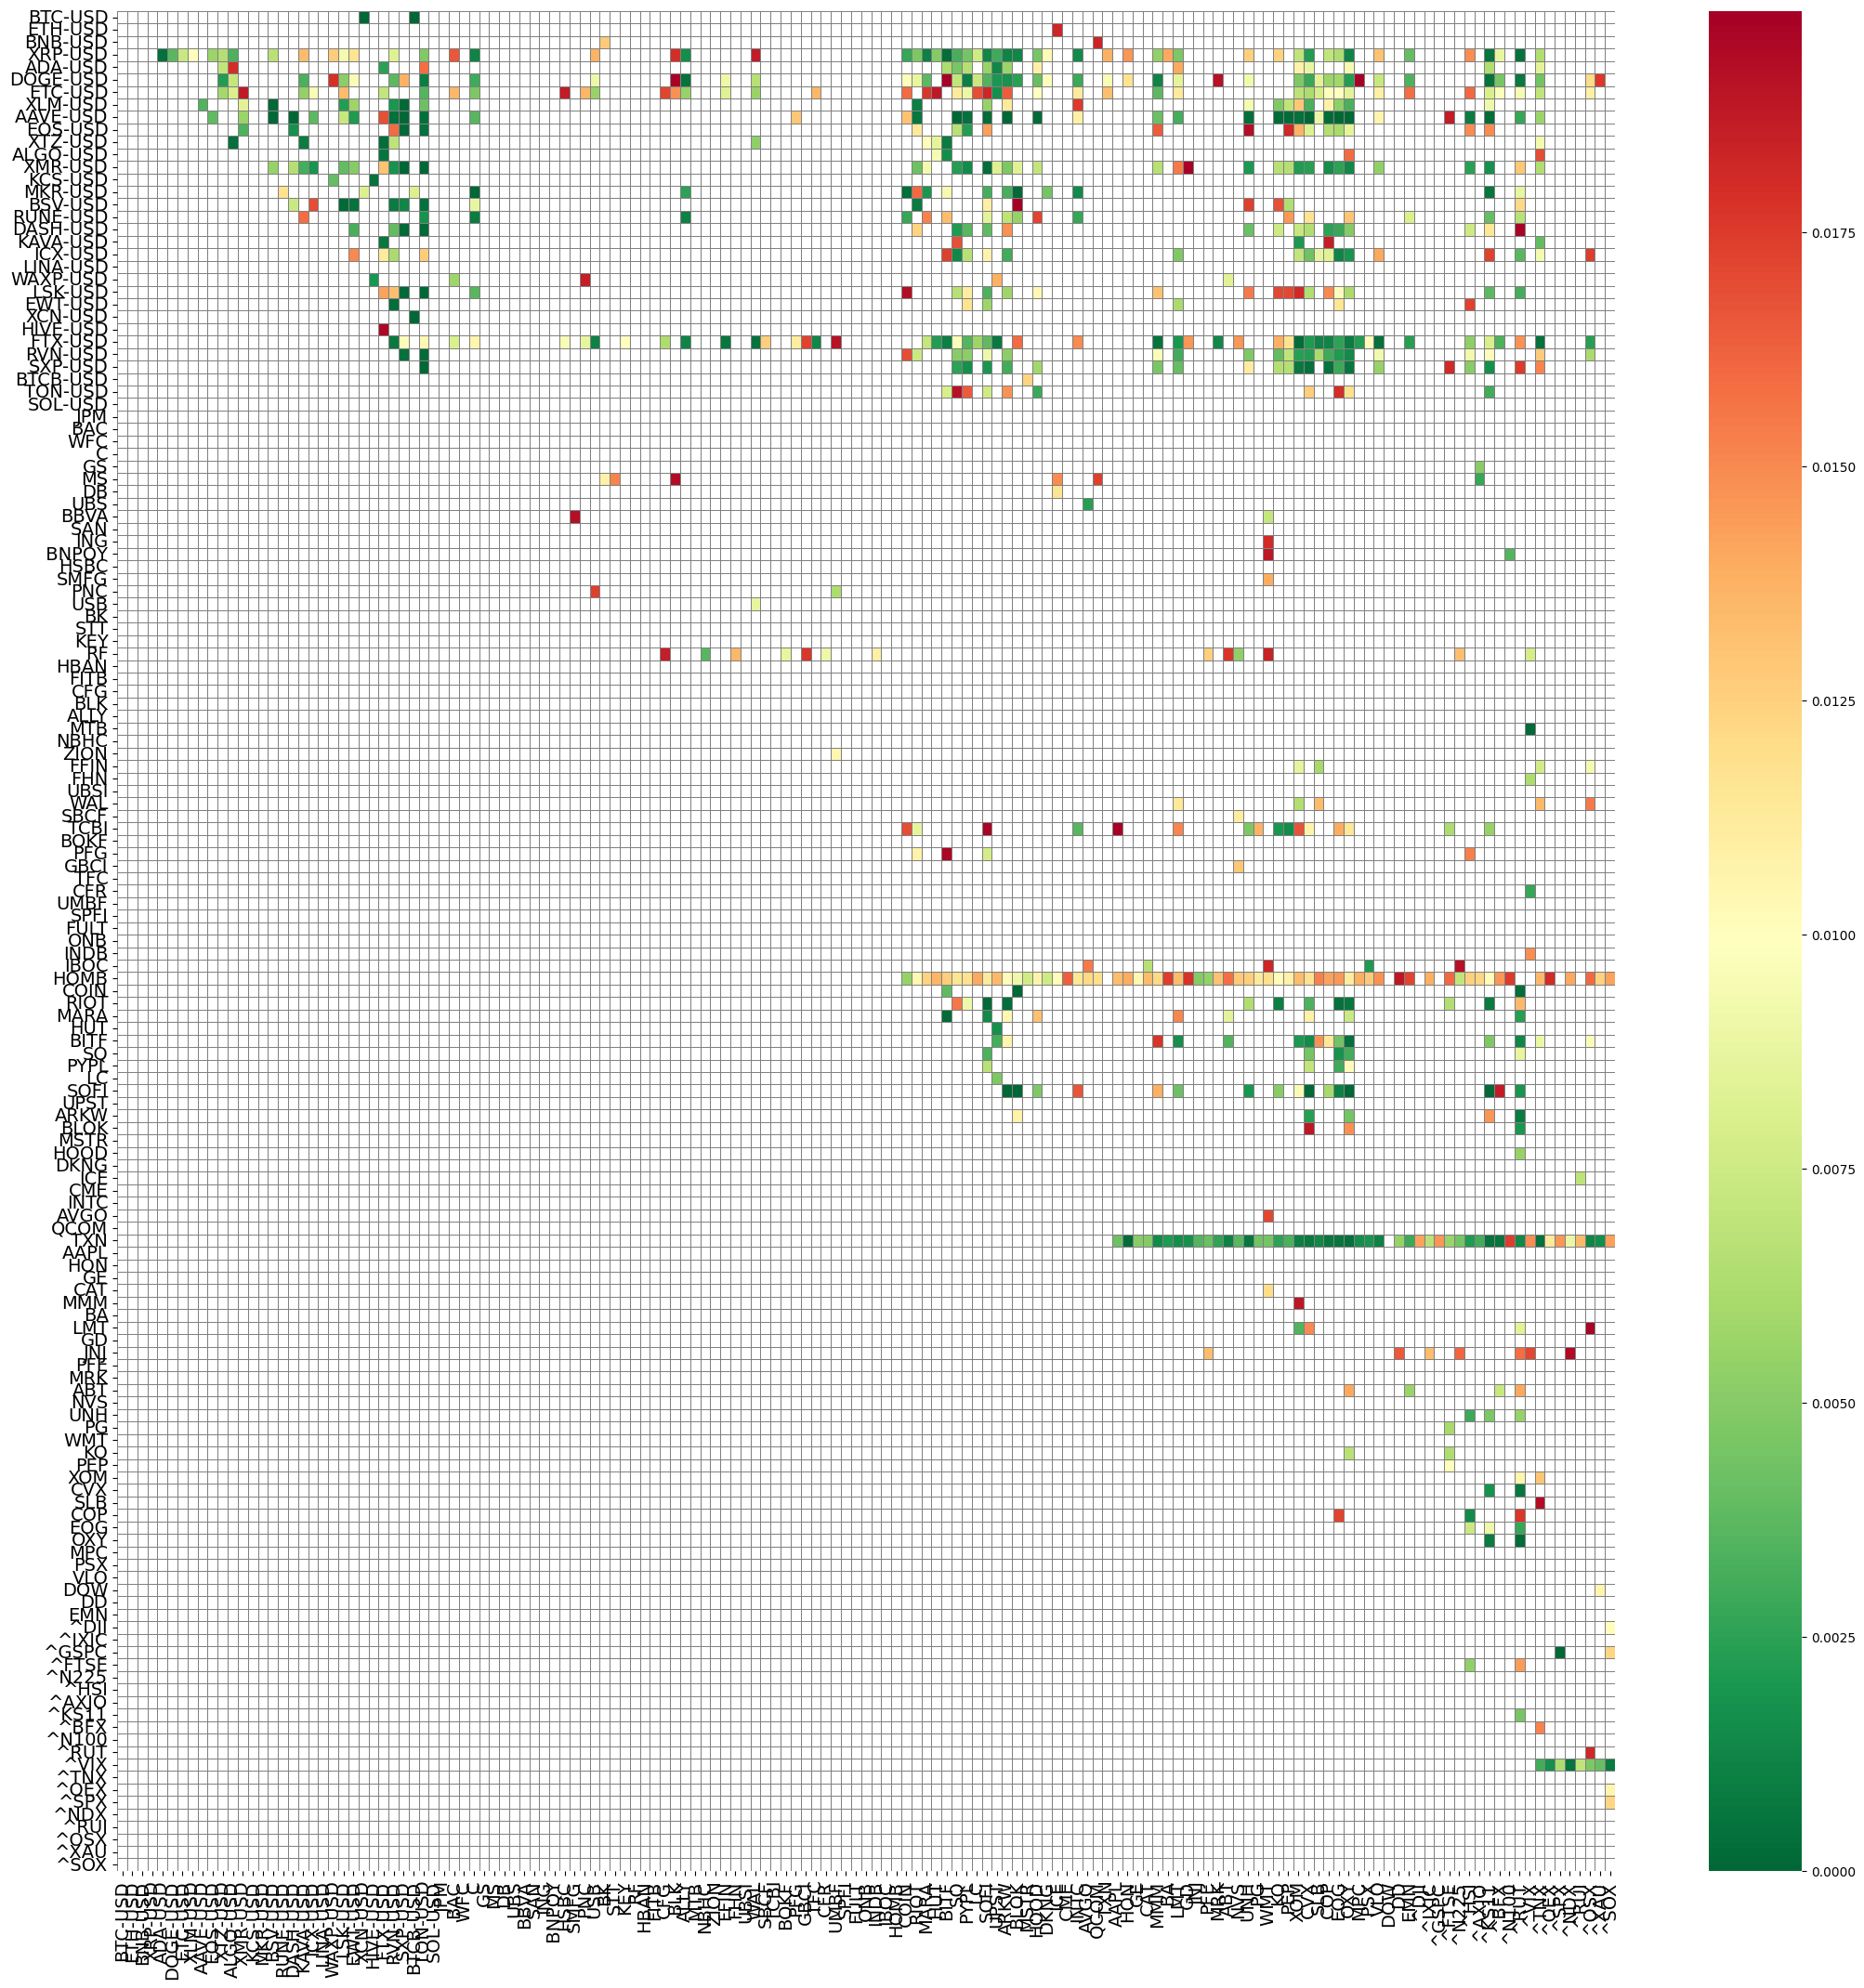

In [ ]:
#@title Get matrix
# This section can take up to 25 mins
P_VALUE_THRESHOLD = 0.02
pvalues, pairs = find_cointegrated_pairs(
    uts_sanitized, p_value_threshold=P_VALUE_THRESHOLD)

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=uts_sanitized.keys(),
                      yticklabels=uts_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(pvalues > (P_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
plt.show()

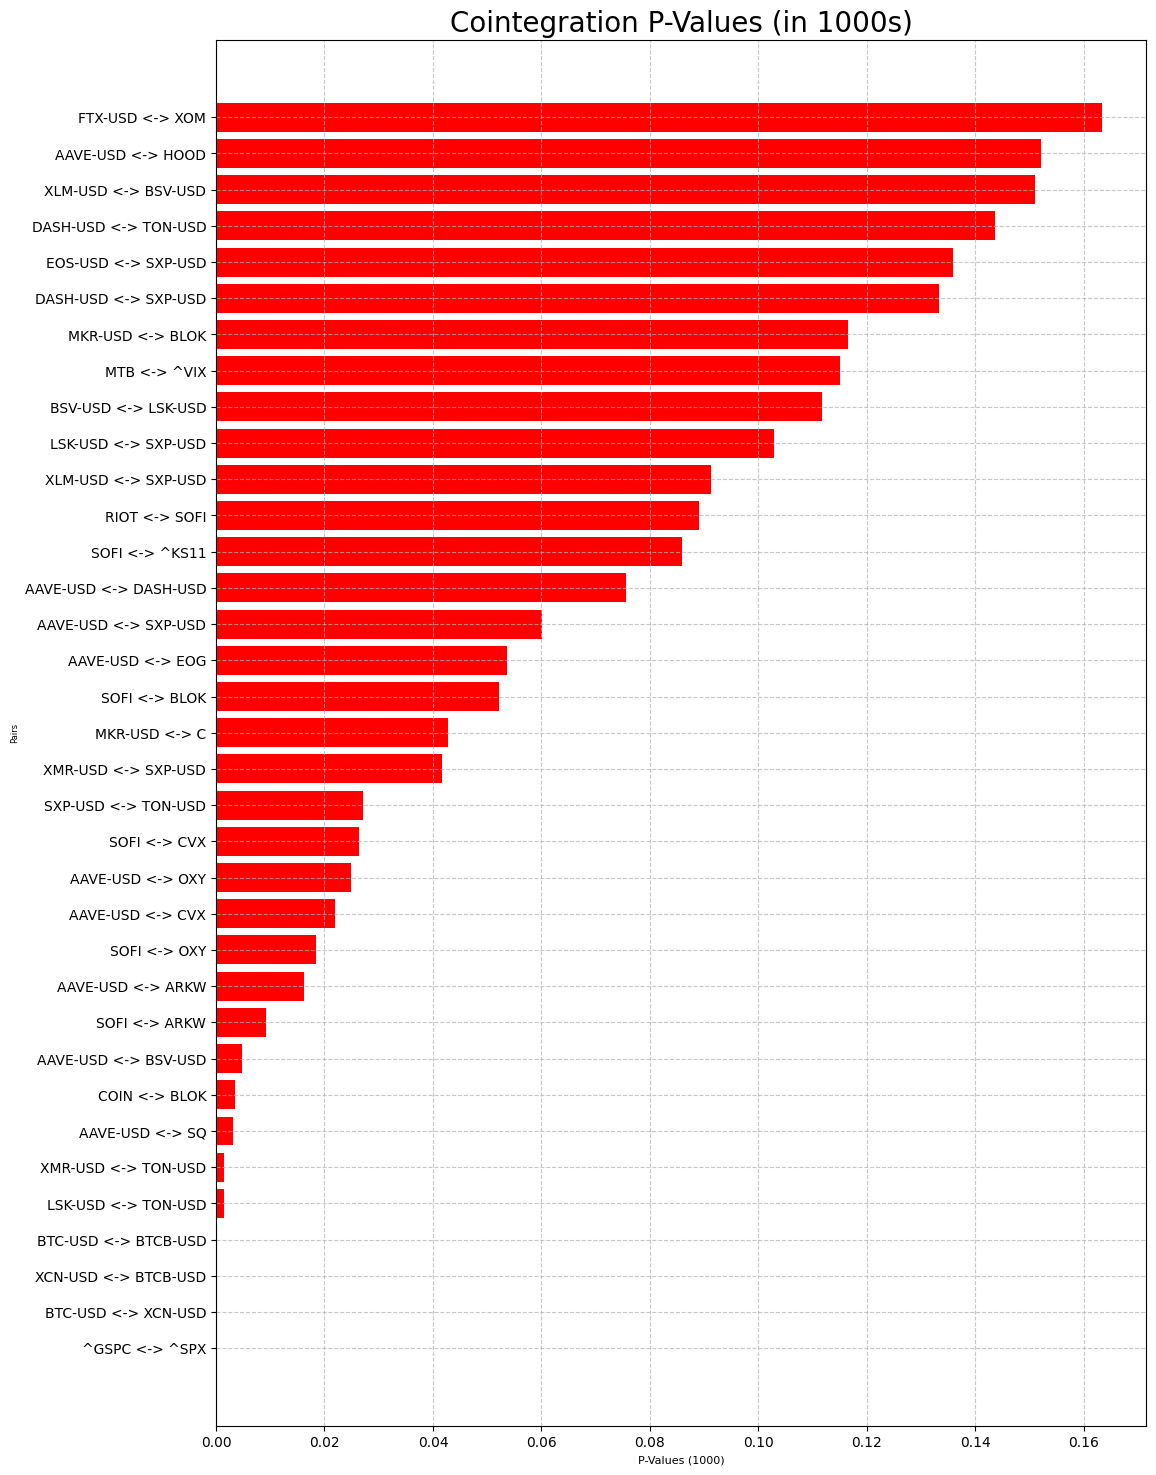

In [ ]:
#@title Get chart
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse = False  )
sorted_pairs = sorted_pairs[0:35]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sorted_pairs if y1 != y2 ])

plt.figure(figsize=(12, 18))
plt.barh(sorted_pairs_labels,
         pairs_p_values, color='red')
plt.xlabel('P-Values (1000)', fontsize=8)
plt.ylabel('Pairs', fontsize=6)
plt.title('Cointegration P-Values (in 1000s)', fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Выбор до 50 наиболее коинтегрированных пар (без одинаковых активов)
top_pairs = []
for pair1, pair2, p_value in pairs:
    if len(top_pairs) >= 50:
        break  # Останавливаемся, если уже есть 50 пар
    if pair1 != pair2 and (pair1, pair2) not in top_pairs and (pair2, pair1) not in top_pairs:
        top_pairs.append((pair1, pair2, p_value))

# Вывод списка пар
print("Наиболее коинтегрированные пары:")
for pair1, pair2, p_value in top_pairs:
    print(f"{pair1} - {pair2}: p-value = {p_value:.4f}")

Наиболее коинтегрированные пары:
BTC-USD - XCN-USD: p-value = 0.0000
BTC-USD - BTCB-USD: p-value = 0.0000
ETH-USD - ICE: p-value = 0.0183
BNB-USD - BK: p-value = 0.0127
BNB-USD - QCOM: p-value = 0.0184
XRP-USD - ADA-USD: p-value = 0.0004
XRP-USD - DOGE-USD: p-value = 0.0037
XRP-USD - ETC-USD: p-value = 0.0073
XRP-USD - XLM-USD: p-value = 0.0100
XRP-USD - EOS-USD: p-value = 0.0056
XRP-USD - XTZ-USD: p-value = 0.0066
XRP-USD - ALGO-USD: p-value = 0.0034
XRP-USD - BSV-USD: p-value = 0.0067
XRP-USD - KAVA-USD: p-value = 0.0133
XRP-USD - WAXP-USD: p-value = 0.0127
XRP-USD - LSK-USD: p-value = 0.0094
XRP-USD - EWT-USD: p-value = 0.0116
XRP-USD - RVN-USD: p-value = 0.0083
XRP-USD - TON-USD: p-value = 0.0048
XRP-USD - BAC: p-value = 0.0166
XRP-USD - C: p-value = 0.0012
XRP-USD - USB: p-value = 0.0137
XRP-USD - BLK: p-value = 0.0180
XRP-USD - ALLY: p-value = 0.0016
XRP-USD - WAL: p-value = 0.0187
XRP-USD - COIN: p-value = 0.0028
XRP-USD - RIOT: p-value = 0.0047
XRP-USD - MARA: p-value = 0.0011


In [ ]:
import pandas as pd
import seaborn as sns
from google.colab import files  # Для скачивания файла
import yfinance as yf
import os
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint

# Ваши функции
def calculate_profit(signals, prices):
    """
    Calculate cumulative profit based on trading signals and stock prices.
    """
    profit = pd.DataFrame(index=prices.index)
    profit['profit'] = 0.0
    buys = signals[signals['orders'] == 1].index
    sells = signals[signals['orders'] == -1].index

    # Проверка на пустые списки
    if len(buys) == 0 or len(sells) == 0:
        return pd.Series(0, index=prices.index)  # Или другой способ обработки

    while sells[0] < buys[0]:
        # These are long only strategies, we cannot start with sell
        sells = sells[1:]
    if len(sells) < len(buys):
        # Assume we sell at the end
        sells = sells.append(pd.Index(prices.tail(1).index))
    buy_prices = prices.loc[buys]
    sell_prices = prices.loc[sells]
    profit.loc[sells, 'profit'] = sell_prices.values - buy_prices.values
    profit['profit'] = profit['profit'].fillna(0)
    # Make profit cumulative
    profit['cum_profit'] = profit['profit'].cumsum()
    return profit['cum_profit']


# Загрузка и подготовка данных
data_map = {}
for ticker in universe_tickers:
    data_map[ticker] = load_ticker_ts_df(ticker, START_DATE, END_DATE)
uts_sanitized = sanitize_data(data_map)
# DataFrame для хранения результатов
results = pd.DataFrame(columns=["Pair1", "Pair2", "Profit"])

# Цикл по всем комбинациям пар
for i in range(len(universe_tickers)):
    for j in range(i + 1, len(universe_tickers)):
        pair1, pair2 = universe_tickers[i], universe_tickers[j]
        # Пропускаем пары с BTCB-USD
        if "BTCB-USD" in (pair1, pair2):
            continue
        # Проверка наличия данных для обеих пар
        if pair1 not in uts_sanitized or pair2 not in uts_sanitized:
            print(f"Данные отсутствуют для пары: {pair1}, {pair2}")
            continue
        # Использование ваших функций
        signals_df1 = signals_zscore_evolution(uts_sanitized[pair1]["Adj Close"], uts_sanitized[pair2]["Adj Close"])
        profit_df1 = calculate_profit(signals_df1, uts_sanitized[pair1]["Adj Close"])
        profit = profit_df1.iloc[-1]  # Получение последнего значения прибыли
        # Исправление: использование pd.concat()
        results = pd.concat([results, pd.DataFrame({"Pair1": [pair1], "Pair2": [pair2], "Profit": [profit]})], ignore_index=True)

# Сортировка и выбор 50 лучших результатов
top_50_results = results.nlargest(50, "Profit")

# Вывод списка пар с доходностью
print(top_50_results[["Pair1", "Pair2", "Profit"]].to_string())


# Сохранение результатов в файл CSV (опционально)
#top_50_results.to_csv("top_50_pairs.csv", index=False)
#files.download("top_50_pairs.csv")

        Pair1     Pair2   Profit
19    BTC-USD  WAXP-USD 21037.04
1     BTC-USD   BNB-USD 17974.71
26    BTC-USD   SXP-USD 14867.61
4     BTC-USD  DOGE-USD 13059.70
25    BTC-USD   RVN-USD 10051.97
7     BTC-USD  AAVE-USD  9531.70
13    BTC-USD   MKR-USD  6690.70
20    BTC-USD   LSK-USD  5493.43
21    BTC-USD   EWT-USD  4937.21
27    BTC-USD   TON-USD  2296.53
320   MKR-USD  WAXP-USD  2088.39
33    ETH-USD   ETC-USD  2068.14
23    BTC-USD  HIVE-USD  1925.95
32    ETH-USD  DOGE-USD  1666.38
51    ETH-USD  HIVE-USD  1412.71
315   MKR-USD   BSV-USD  1337.30
324   MKR-USD  HIVE-USD  1265.99
325   MKR-USD   FTX-USD  1026.28
29    ETH-USD   BNB-USD   989.70
49    ETH-USD   EWT-USD   925.49
48    ETH-USD   LSK-USD   857.28
47    ETH-USD  WAXP-USD   734.95
46    ETH-USD  LINA-USD   691.61
54    ETH-USD   SXP-USD   597.42
341   BSV-USD   SXP-USD   415.02
289   XMR-USD  WAXP-USD   341.06
334   BSV-USD  WAXP-USD   329.68
295   XMR-USD   RVN-USD   329.01
77    BNB-USD   XCN-USD   315.47
282   XMR-

In [89]:
import pandas as pd
import seaborn as sns
from google.colab import files  # Для скачивания файла
import yfinance as yf
import os
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint
from itertools import islice

# Поиск 5000 наиболее доходных комбинаций
results = pd.DataFrame(columns=["Pair1", "Pair2", "Profit"])
for i in range(len(universe_tickers)):
    for j in range(i + 1, len(universe_tickers)):
        pair1, pair2 = universe_tickers[i], universe_tickers[j]

        # Проверка наличия данных для обеих пар
        if pair1 not in uts_sanitized or pair2 not in uts_sanitized:
            print(f"Данные отсутствуют для пары: {pair1}, {pair2}")
            continue
        # Использование ваших функций
        signals_df1 = signals_zscore_evolution(uts_sanitized[pair1]["Adj Close"], uts_sanitized[pair2]["Adj Close"])
        profit_df1 = calculate_profit(signals_df1, uts_sanitized[pair1]["Adj Close"])
        profit = profit_df1.iloc[-1]  # Получение последнего значения прибыли
        # Исправление: использование pd.concat()
        results = pd.concat([results, pd.DataFrame({"Pair1": [pair1], "Pair2": [pair2], "Profit": [profit]})], ignore_index=True)

# Фильтрация top_5000_results для удаления пар с нулевой или отрицательной доходностью
top_5000_results = results.nlargest(10000, "Profit")
top_5000_results = top_5000_results[top_5000_results["Profit"] > 30]

# Extract the desired columns
top_5000_results = top_5000_results[["Pair1", "Pair2", "Profit"]]

top_profit = []

for pair1, pair2, profit in top_5000_results.values:
    if len(top_profit) >= 10000:
        break  # Останавливаемся, если уже есть 5000 пар
    if pair1 != pair2 and (pair1, pair2) not in top_profit and (pair2, pair1) not in top_profit:
        pair = pair1 + ":" + pair2
        top_profit.append((pair1, pair2, pair, round(profit,2)))


# Поиск коинтегрированных пар
P_VALUE_THRESHOLD = 0.02
p_values, pairs = find_cointegrated_pairs(
    uts_sanitized, p_value_threshold=P_VALUE_THRESHOLD)



# Сортировка пар в порядке возрастания p-значения

pairs.sort(key=lambda x: x[2], reverse = False  )

# Выбор до 5000 наиболее коинтегрированных пар (без одинаковых активов)
top_pairs = []
for pair1, pair2, p_values in pairs:
    if len(top_pairs) >= 10000:
        break  # Останавливаемся, если уже есть 5000 пар
    if pair1 != pair2 and (pair1, pair2) not in top_pairs and (pair2, pair1) not in top_pairs:
        pair = pair1 + ":" + pair2
        top_pairs.append((pair1, pair2, pair, round(p_values * 1000, 5)))

# p_values сортировка
top_pairs.sort(key=lambda x: p_values, reverse = False)


# Создание словаря {пара: прибыль}
profit_dict = {pair: profit for _, _, pair, profit in top_profit}

# Добавление прибыли в top_pairs и удаление несовпадений
top_pairs_with_profit = []
for pair1, pair2, pair, p_values in top_pairs:
    pair = pair1 + ":" + pair2
    if pair in profit_dict:
        profit = profit_dict[pair]
        top_pairs_with_profit.append((pair1, pair2, pair, p_values, profit))


# Создание словаря с местами по доходности
profit_ranks = {pair: rank + 1 for rank, (_, _, pair, profit) in enumerate(top_profit)}

# Создание словаря с местами по коинтеграции
coint_ranks = {pair: rank + 1 for rank, (_, _, pair, p_value, _) in enumerate(top_pairs_with_profit)}


# Создание списка с рейтингом пар
ranked_pairs = []
for pair1, pair2, pair, p_values, profit in top_pairs_with_profit:
    coint_rank = coint_ranks[pair]  # Удалено get()
    profit_rank = profit_ranks[pair]  # Удалено get()
    total_score = profit_rank + coint_rank
    ranked_pairs.append((pair1, pair2, profit, profit_rank, p_values, coint_rank, total_score))



# Сортировка по total_score
ranked_pairs.sort(key=lambda x: x[-1])

# Добавление общего места
for i, pair_data in enumerate(ranked_pairs):
    ranked_pairs[i] = pair_data + (i + 1,)

# Вывод рейтинга
print("Рейтинг пар по доходности и коинтеграции:")
print("-" * 140)
print(f"{'Пара 1':<15} {'Пара 2':<15} {'Доходность':>12} {'Место дох.':>12} {'Ур. коинт.':>12} {'Место коинт.':>12} {'Общий балл':>12} {'Общее место':>12}")
print("-" * 140)
for pair1, pair2, profit, profit_rank, p_values, coint_rank, total_score, overall_rank in islice(ranked_pairs, 2000):
    if pair1 != pair2:
        print(f"{pair1:<15} {pair2:<15} {profit:8.2f} {profit_rank:12} {p_values:12.4f} {coint_rank:8} {total_score:8} {overall_rank:12}")


# Сохранение рейтинга в файл CSV
ranked_pairs_df = pd.DataFrame(ranked_pairs, columns=["Pair1", "Pair2", "Profit", "Profit Rank", "Cointegration Level", "Cointegration Rank", "Total Score", "Overall Rank"])
ranked_pairs_df.to_csv("ranked_pairs.csv", index=False)

# Скачивание файла
files.download("ranked_pairs.csv")

Рейтинг пар по доходности и коинтеграции:
--------------------------------------------------------------------------------------------------------------------------------------------
Пара 1          Пара 2            Доходность   Место дох.   Ур. коинт. Место коинт.   Общий балл  Общее место
--------------------------------------------------------------------------------------------------------------------------------------------
BTCB-USD        MSTR            73895.36            2      12.4091       69       71            1
BTC-USD         BTCB-USD        16771.06          168       0.0000        1      169            2
MKR-USD         COIN             2909.63          215       0.2700       13      228            3
MKR-USD         C                2256.98          225       0.0428        6      231            4
MKR-USD         MARA             4435.31          207       1.9745       29      236            5
MKR-USD         INTC             1943.72          233       1.4426       24 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Strategy part

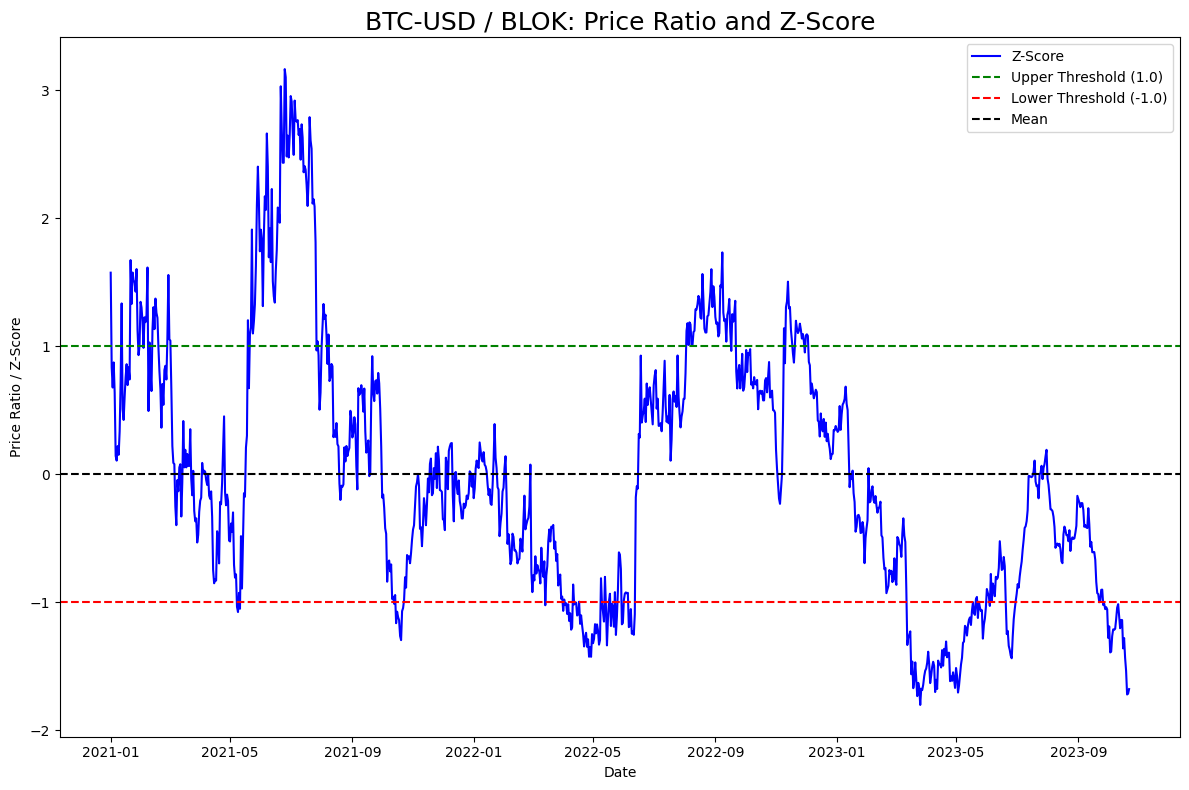

In [ ]:
#@title Split data look at borders
TRAIN = int(len(uts_sanitized["BTC-USD"]) * 0.85)
TEST = len(uts_sanitized["BTC-USD"]) - TRAIN

AAVE_ts = uts_sanitized["BTC-USD"]["Adj Close"][:TRAIN]
C_ts = uts_sanitized["BLOK"]["Adj Close"][:TRAIN]
# Calculate price ratio (AAVE-USD price / C price)
ratios = C_ts/AAVE_ts
fig, ax = plt.subplots(figsize=(12, 8))
ratios_mean = np.mean(ratios)
ratios_std = np.std(ratios)
ratios_zscore = (ratios - ratios_mean) / ratios_std
ax.plot(ratios.index, ratios_zscore, label="Z-Score", color='blue')
# Plot reference lines
ax.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
ax.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
ax.axhline(0, color="black", linestyle='--', label="Mean")
ax.set_title('BTC-USD / BLOK: Price Ratio and Z-Score', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Price Ratio / Z-Score')
ax.legend()
plt.tight_layout()
plt.show()

<Figure size 2600x1600 with 0 Axes>

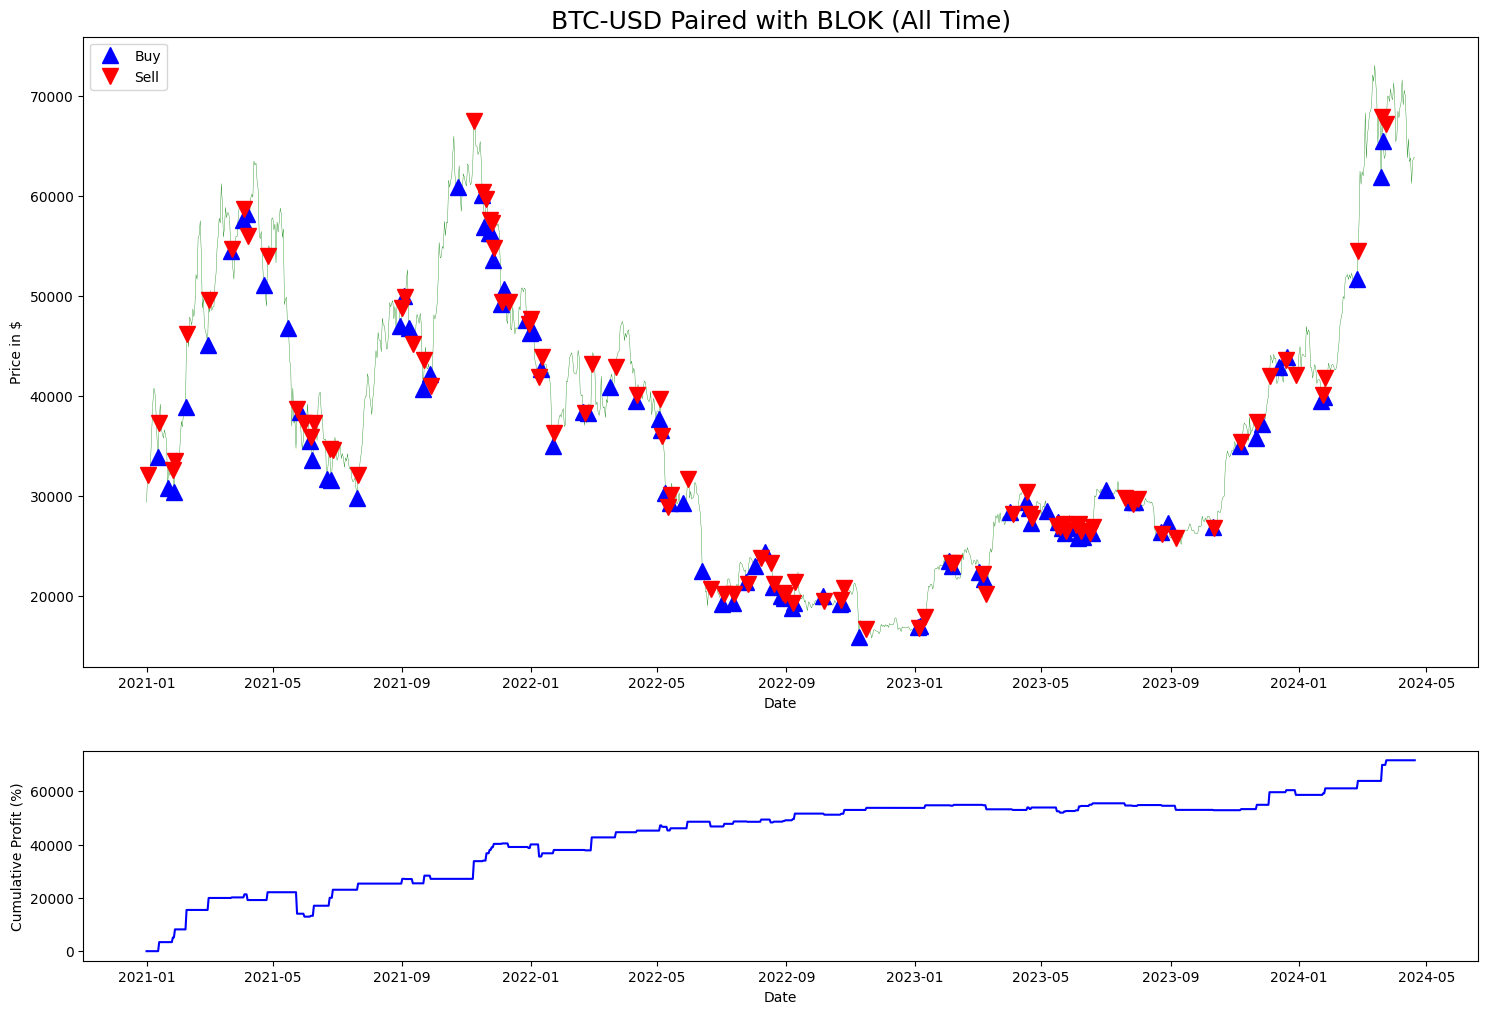

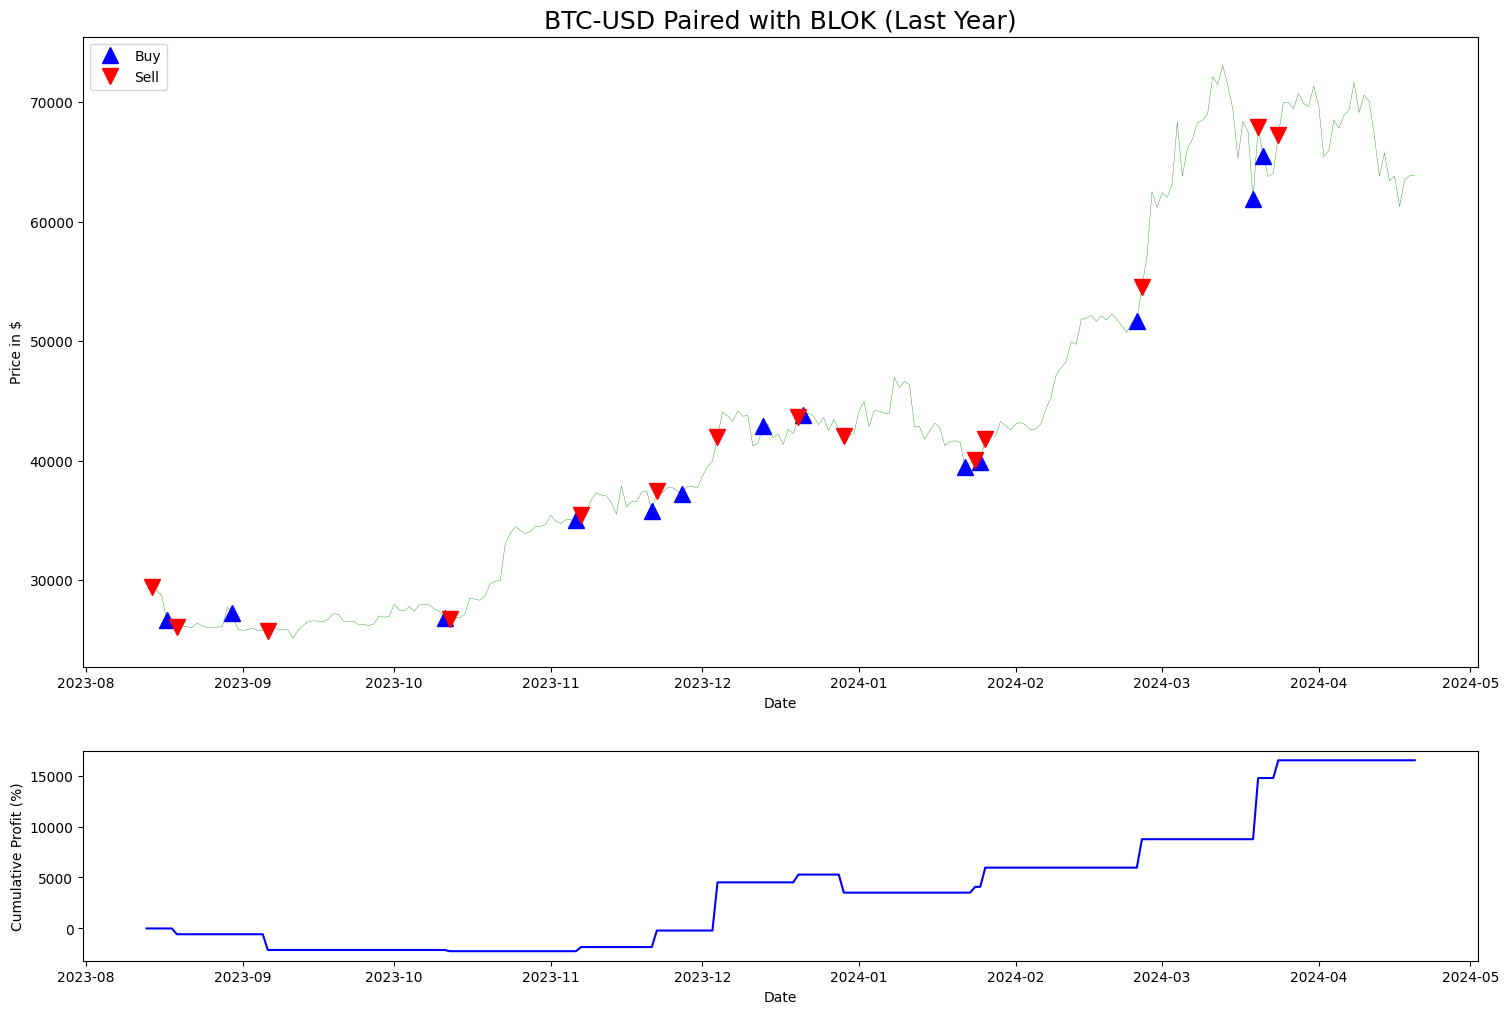

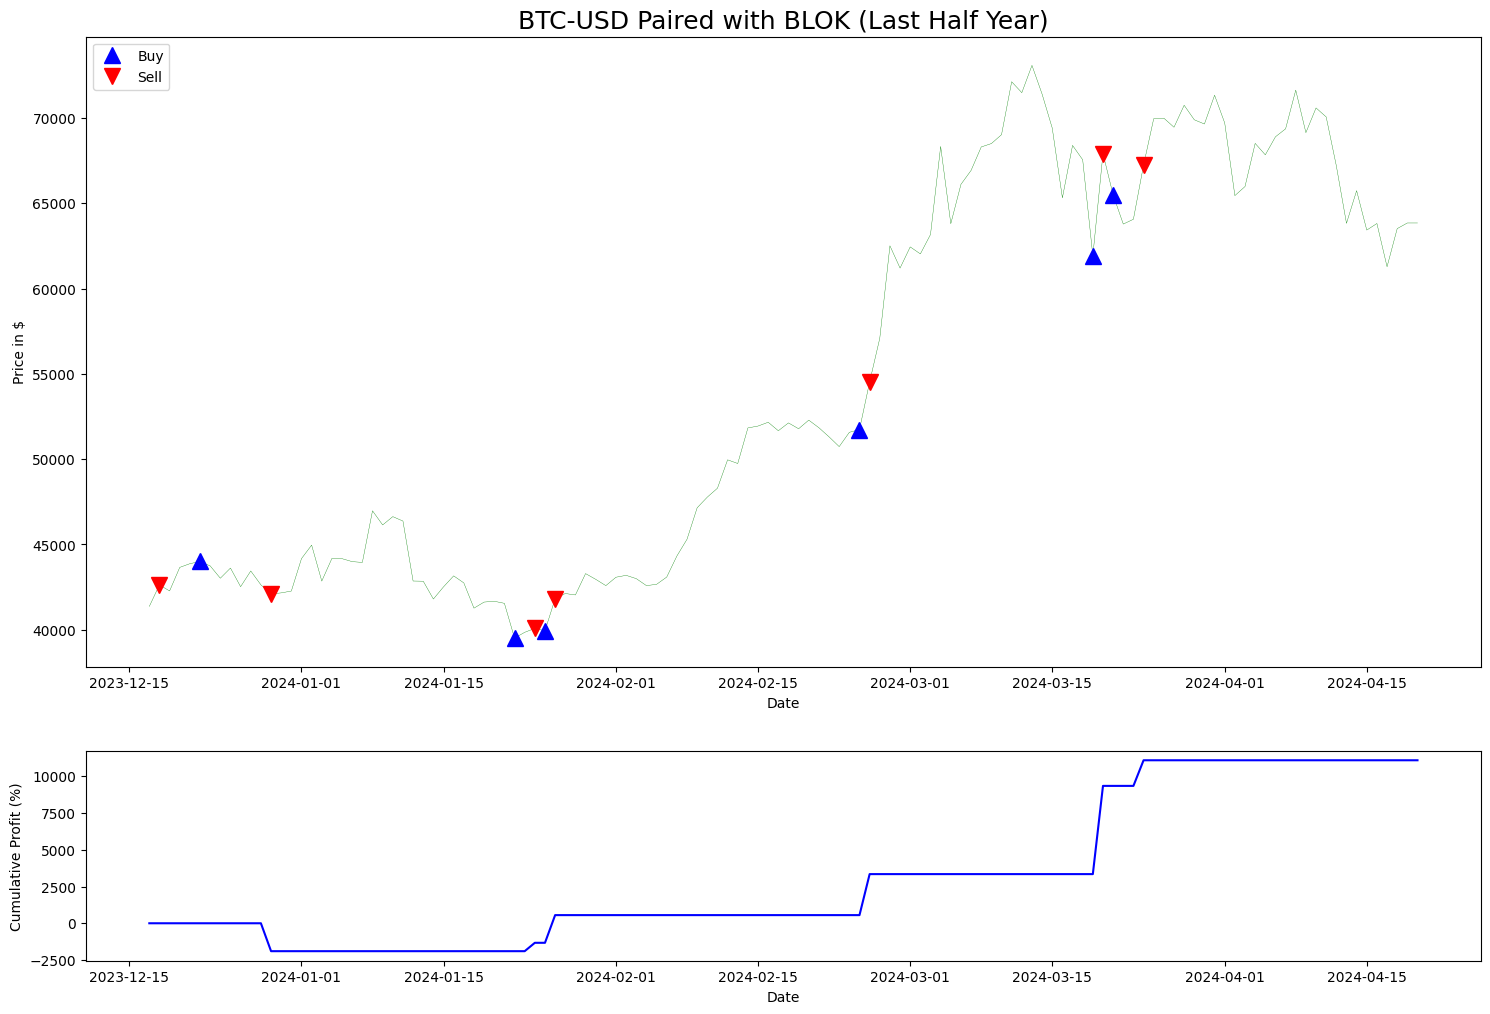

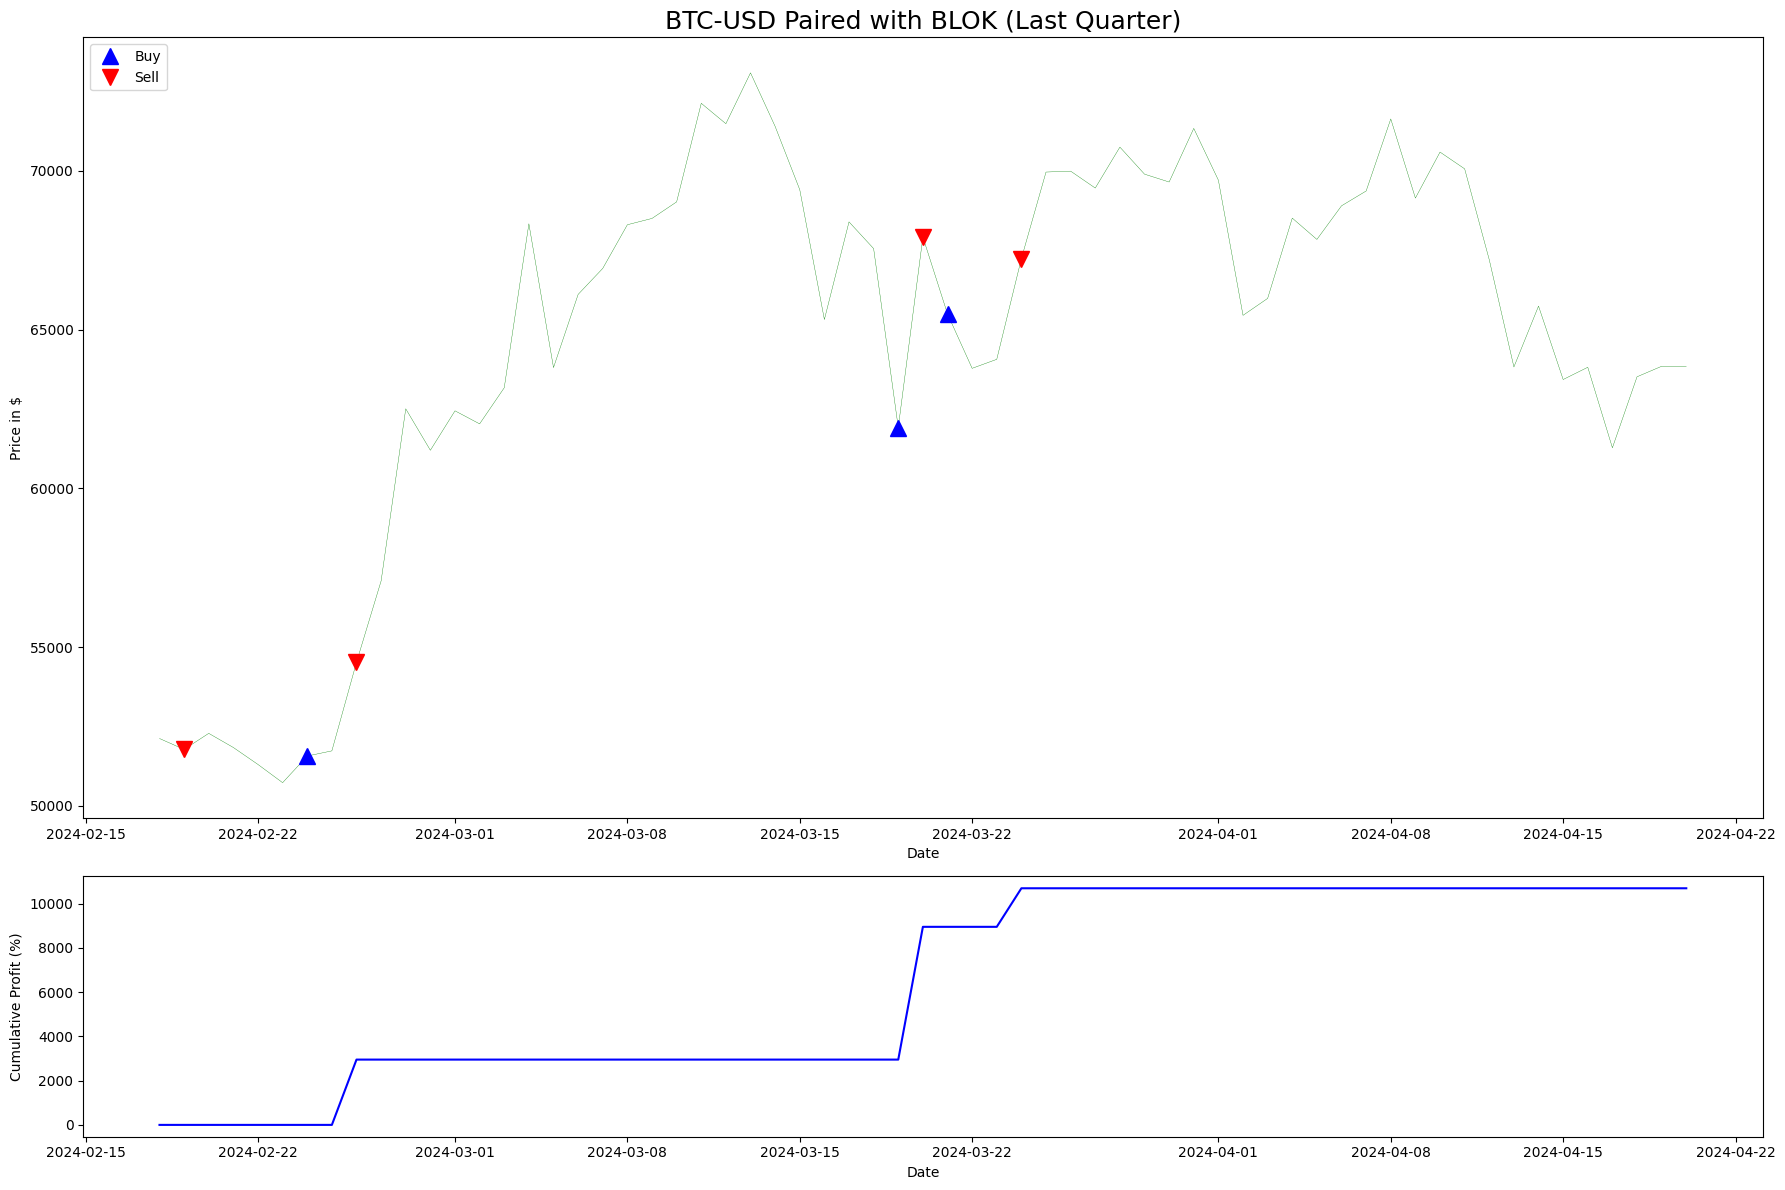

In [ ]:
import pandas as pd


AAVE_ts = uts_sanitized["BTC-USD"]["Adj Close"]
C_ts = uts_sanitized["BLOK"]["Adj Close"]


AAVE_tss = ["BTC-USD"] # Переменные для динамического отображения
C_tss = ["BLOK"]


aave_name = C_tss[0] # Костыль чтобы не переписывать код отображения названий
c_name = AAVE_tss[0]

# Функция для создания графика с заданным временным отрезком и заголовком
def plot_with_timerange(ts1, ts2, timerange):
    signals_df = signals_zscore_evolution(ts1[timerange], ts2[timerange])
    profit_df = calculate_profit(signals_df, ts1[timerange])
    ax, _ = plot_strategy(ts1[timerange], signals_df, profit_df)
    ax.set_title(f"{ts2.name} Paired with {ts1.name} ({timerange.start.date()} - {timerange.end.date()})", fontsize=14)
    return ax

plt.figure(figsize=(26, 16))  # Изменен размер для 4 графиков

# График за всё время
signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
ax1, _ = plot_strategy(AAVE_ts, signals_df1, profit_df1)
ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f"{c_name} Paired with {aave_name} (All Time)", fontsize=18)

# График за год
last_year = AAVE_ts.index[-252:]
signals_df2 = signals_zscore_evolution(AAVE_ts[last_year], C_ts[last_year])
profit_df2 = calculate_profit(signals_df2, AAVE_ts[last_year])
ax2, _ = plot_strategy(AAVE_ts[last_year], signals_df2, profit_df2)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f"{c_name} Paired with {aave_name} (Last Year)", fontsize=18)

# График за полгода
last_half_year = AAVE_ts.index[-126:]
signals_df3 = signals_zscore_evolution(AAVE_ts[last_half_year], C_ts[last_half_year])
profit_df3 = calculate_profit(signals_df3, AAVE_ts[last_half_year])
ax3, _ = plot_strategy(AAVE_ts[last_half_year], signals_df3, profit_df3)
ax3.legend(loc='upper left', fontsize=10)
ax3.set_title(f"{c_name} Paired with {aave_name} (Last Half Year)", fontsize=18)

# График за квартал
last_quarter = AAVE_ts.index[-63:]
signals_df4 = signals_zscore_evolution(AAVE_ts[last_quarter], C_ts[last_quarter])
profit_df4 = calculate_profit(signals_df4, AAVE_ts[last_quarter])
ax4, _ = plot_strategy(AAVE_ts[last_quarter], signals_df4, profit_df4)
ax4.legend(loc='upper left', fontsize=10)
ax4.set_title(f"{c_name} Paired with {aave_name} (Last Quarter)", fontsize=18)

plt.tight_layout()
plt.show()

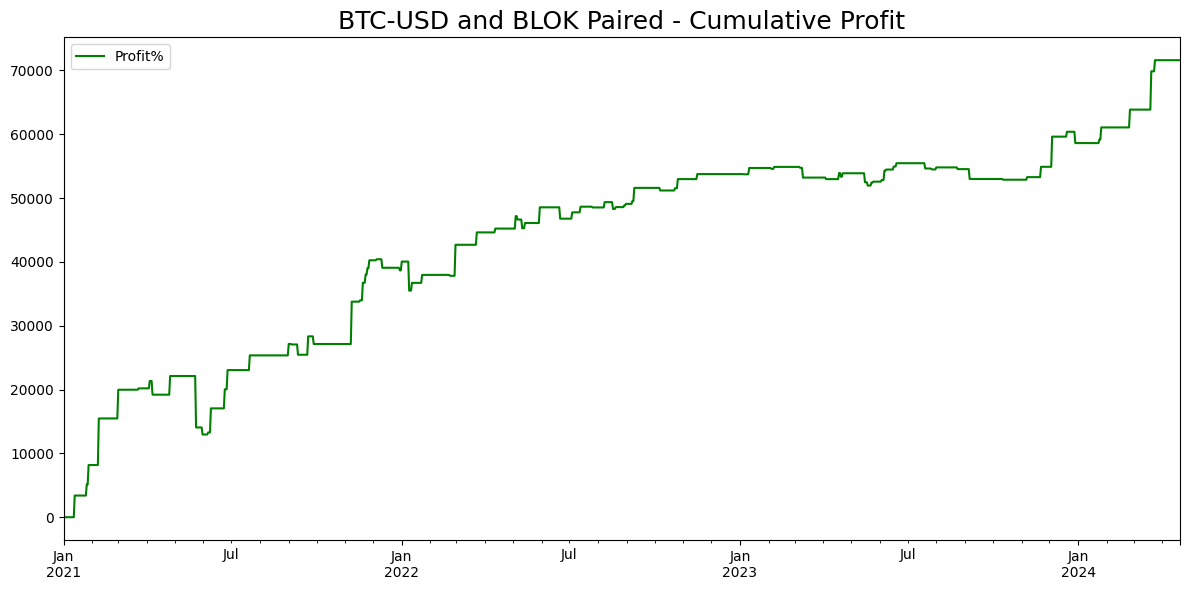

In [ ]:
#@title Calculate results
signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
signals_df2 = signals_zscore_evolution(AAVE_ts, C_ts, first_ticker=False)
profit_df2 = calculate_profit(signals_df2, C_ts)

plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'{c_name} and {aave_name} Paired - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()